# Reevaluate metrics

In [9]:
import numpy as np
import torch

from gnn_tracking.metrics.cluster_metrics import tracking_metric_dfs
from gnn_tracking.postprocessing.clusterscanner import sort_according_to_mask
from gnn_tracking_hpo.trainable import PretrainedECTCNTrainable

import matplotlib.pyplot as plt
plt.style.use('sss1.mplstyle')

## Load model

In [ ]:
trainable = PretrainedECTCNTrainable.reinstate(
    "fixed-ec-50029d0b",
    "ba8a937f",
    epoch=-1,
    config_override=dict(n_graphs_train=1, n_graphs_val=300, n_graphs_test=1)
)

[17:37:30 HPO] DEBUG: Loading config from /home/kl5675/ray_results/fixed-ec-50029d0b/PretrainedECTrainable_ba8a937f_10_val_batch_size=1,adam_amsgrad=False,adam_beta1=0.9000,adam_beta2=0.9990,adam_eps=0.0000,adam_wei_2023-05-04_18-10-52/params.json
[17:37:31 HPO] INFO: I'm running on a node with job ID=48047230
[17:37:31 HPO] WARNING: Dispatcher ID was not set. This should be set by the dispatcher as a class attribute to the trainable.
[17:37:31 HPO] INFO: The ID of my dispatcher is 0
[17:37:31 SlurmControl] DEBUG: Refreshing control config from /home/kl5675/ray_slurm_control.yaml
[17:37:31 HPO] DEBUG: Got config
┌───────────────────────────────┬──────────────────────────────────────────┐
│ _val_batch_size               │ 1                                        │
│ adam_amsgrad                  │ False                                    │
│ adam_beta1                    │ 0.9                                      │
│ adam_beta2                    │ 0.999                                 

In [10]:
from gnn_tracking.postprocessing.dbscanscanner import dbscan_scan
from functools import partial

trainable.trainer.clustering_functions = {
    "dbscan": partial(dbscan_scan, n_trials=10, n_jobs=6, guide="trk.double_majority_pt0.9",)
}

## Default Evaluate

In [11]:
from gnn_tracking.training.tcn_trainer import TCNTrainer
trainer: TCNTrainer = trainable.trainer
trainer.max_batches_for_clustering = 30
results = trainer.test_step(max_batches=30)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: Type

In [12]:
trainer._best_cluster_params

{'dbscan': {'eps': 0.9530987000302845, 'min_samples': 1}}

## Evaluate in detail

In [17]:
from gnn_tracking.metrics.cluster_metrics import count_tracking_metrics
import itertools


def get_h_df(data, model_output, clusters):
    m = model_output["ec_hit_mask"].cpu().numpy()

    def prep(x):
        return sort_according_to_mask([x.cpu().numpy()], [m])[0]

    return pd.DataFrame({
        "c": np.concatenate([clusters, np.full(data.x.shape[0] - clusters.shape[0], -1)]),
        "id": prep(data.particle_id),
        "reconstructable": prep(data.reconstructable),
        "pt": prep(data.pt),
        "eta": prep(data.x[:, 3]),
    })




In [18]:
from tqdm.contrib.concurrent import process_map
from gnn_tracking.postprocessing.dbscanscanner import dbscan
import torch
import pandas as pd

trainer = trainable.trainer
model = trainer.model
model.eval()

def get_m_data(data):
    model_output = trainer.evaluate_model(
        data,
        mask_pids_reco=False,
    )
    clusters = dbscan(model_output["x"], eps=trainer._best_cluster_params["dbscan"]["eps"])
    h_df = get_h_df(data, model_output, clusters)
    c_df = tracking_metric_dfs(h_df)
    return h_df, c_df

In [20]:
def shorten_iterator(it, n):
    for i, x in enumerate(it):
        if i >= n:
            break
        yield x

In [159]:
with torch.no_grad():
    m_data = process_map(get_m_data, shorten_iterator(trainer.val_loader, 100), max_workers=6, chunksize=1, total=100)

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: Type

  0%|          | 0/100 [00:00<?, ?it/s]

In [160]:
def tracking_metrics_vs_pt(h_df, c_df, pts):
    for pt_min, pt_max in itertools.pairwise(pts):
        c_mask = (
            (c_df["maj_pt"] < pt_max) &
            (c_df["maj_pt"] >= pt_min) &
            c_df["maj_reconstructable"] &
            c_df["valid_cluster"]
        )
        h_mask = (
            (h_df["pt"] < pt_max) &
            (h_df["pt"] >= pt_min) &
            h_df["reconstructable"].astype(bool)
        )
        yield count_tracking_metrics(c_df, h_df, c_mask, h_mask)

def tracking_metrics_vs_var(h_df, c_df, vars, var="eta", pt_min=0.9):
    for var_min, var_max in itertools.pairwise(vars):
        c_mask = (
            (c_df["maj_pt"] >= pt_min) &
            (c_df[f"maj_{var}"] < var_max) &
            (c_df[f"maj_{var}"] >= var_min) &
            c_df["maj_reconstructable"] &
            c_df["valid_cluster"]
        )
        pid2varmean = h_df[["id", var]].groupby("id")[var].mean().to_dict()
        h_df[f"mean_{var}"] = h_df["id"].map(pid2varmean)
        h_mask = (
            (h_df["pt"] >= pt_min) &
            (h_df[f"mean_{var}"] < var_max) &
            (h_df[f"mean_{var}"] >= var_min) &
            h_df["reconstructable"].astype(bool)
        )
        yield count_tracking_metrics(c_df, h_df, c_mask, h_mask)

In [193]:
list(tracking_metrics_vs_var(h_df, c_df, [-4.5, 4.5], "eta"))

[{'n_particles': 51,
  'n_cleaned_clusters': 42,
  'perfect': 0.5490196078431373,
  'double_majority': 0.7254901960784313,
  'lhc': 0.9523809523809523,
  'fake_perfect': 0.27450980392156865,
  'fake_double_majority': 0.09803921568627451,
  'fake_lhc': 0.047619047619047616}]

In [194]:
list(itertools.pairwise([-6, 0, 6]))

[(-6, 0), (0, 6)]

In [195]:
_rs = list(tracking_metrics_vs_var(h_df, c_df, np.linspace(-6, 6, 20), "eta"))
sum([r["n_particles"] for r in _rs]), sum([r["n_cleaned_clusters"] for r in _rs])

/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/utils/math.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return a / b
/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/utils/math.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return a / b
/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/utils/math.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return a / b
/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/utils/math.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return a / b
/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/utils/math.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return a / b
/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/utils/math.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return a / b


(51, 42)

In [196]:
pts = np.array(np.linspace(0, 3, 20).tolist() + [5.])
etas = np.linspace(-6, 6, 20)
# pts = np.array([0.9, 100])
# etas = np.array([-100, 100])
rs_pt = []
rs_eta = []
for h_df, c_df in m_data:
    rs_pt.extend(list(tracking_metrics_vs_pt(h_df, c_df, pts)))
    rs_eta.extend(list(tracking_metrics_vs_var(h_df, c_df, etas, "eta", pt_min=0.9)))

/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/utils/math.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return a / b
/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/utils/math.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return a / b
/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/utils/math.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return a / b
/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/utils/math.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return a / b
/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/utils/math.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return a / b
/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking/utils/math.py:7: RuntimeWarning: invalid value encountered in scalar divide
  return a / b
/home/kl5675/Documents/23/git_sync/gnn_tracking/src/gnn_tracking

In [197]:
def aggregate(results, key, n_batches):
    assert len(results) % n_batches == 0
    n_bins = len(results) // n_batches
    return (
        [np.nanmean([r[key] for r in results[i::n_bins]]) for i in range(n_bins)],
        [np.nanstd([r[key] for r in results[i::n_bins]]) / np.sqrt(sum(~np.isnan([r[key] for r in results[i::n_bins]]))) for i in range(n_bins)],
    )


In [198]:
from matplotlib import pyplot as plt

def plot_metrics(results, xs, kind):
    n_batches = len(results) // (len(xs)-1)

    fig, ax = plt.subplots()

    y, ey = aggregate(results, "double_majority", n_batches)
    ax.stairs(y, edges=xs)
    ax.errorbar((xs[:-1] + xs[1:])/2, y, yerr=ey, ls="none", c="C0", label="DM")

    y, ey = aggregate(results, "lhc", n_batches)
    ax.stairs(y, edges=xs)
    ax.errorbar((xs[:-1] + xs[1:])/2, y, yerr=ey, ls="none", c="C1", label="LHC")

    y, ey = aggregate(results, "perfect", n_batches)
    ax.stairs(y, edges=xs)
    ax.errorbar((xs[:-1] + xs[1:])/2, y, yerr=ey, ls="none", c="C2", label="Perfect")

    if kind == "pt":
        ax.axvspan(0., 0.9, alpha=0.3, color="gray", label="Performance ignored during training", linestyle="none")
        ax.set_xlabel("$p_T$ [GeV]")
        ax.legend()
    elif kind == "eta":
        ax.set_xlabel("$\eta$")
        ax.legend(title="$p_T > 0.9$ GeV")

    return ax

<Axes: xlabel='$p_T$ [GeV]'>

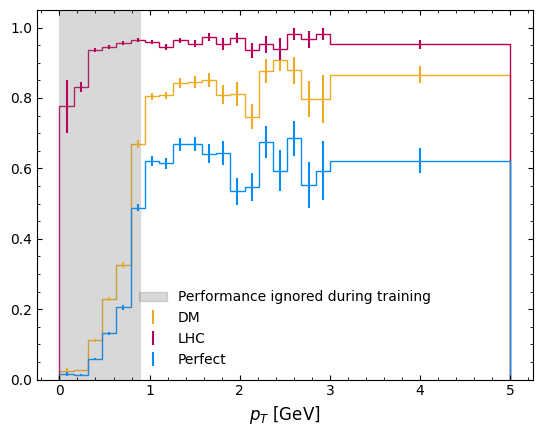

In [199]:
plot_metrics(list(rs_pt), pts, "pt")

/tmp/ipykernel_2628153/4189986375.py:5: RuntimeWarning: Mean of empty slice
  [np.nanmean([r[key] for r in results[i::n_bins]]) for i in range(n_bins)],
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<Axes: xlabel='$\\eta$'>

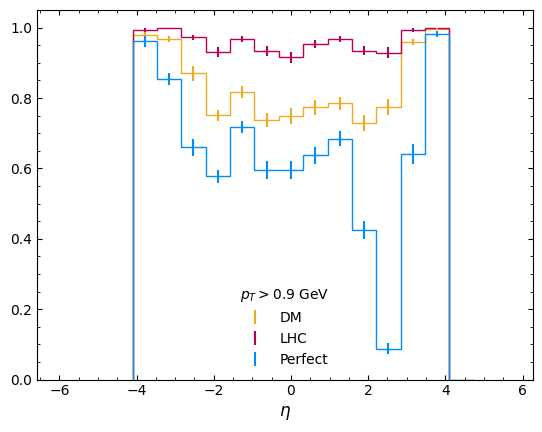

In [200]:
plot_metrics(rs_eta, etas, "eta")

<Axes: >

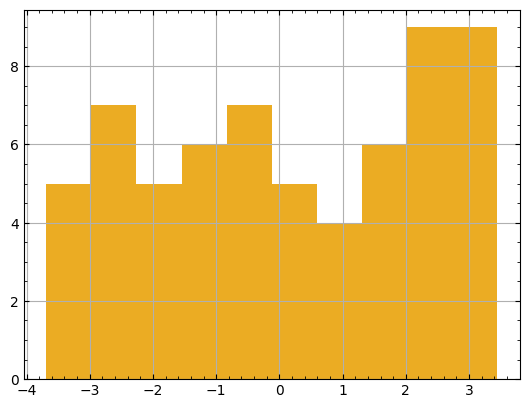

In [119]:
c_df[c_df.maj_pt > 0.9]["maj_eta"].hist()